### ML_Group_8

# 주제: 14-19 회귀분석을 통한 20 서울시 성범죄 발생 수 결과 예측 - 성범죄 원인과 예방정책 분석을 바탕으로


## 사용한 데이터 셋 

- 서울시 5대 범죄 발생현황 통계
https://data.seoul.go.kr/dataList/316/S/2/datasetView.do
- 서울시 5대 범죄 발생장소별 현황 통계
https://data.seoul.go.kr/dataList/10943/C/2/datasetView.do
- 서울시 식품위생업 현황(구별) 통계
https://data.seoul.go.kr/dataList/33/C/2/datasetView.do
- 전국 안전비상벨 위치 표준 데이터
https://www.data.go.kr/data/15028206/standard.do
- 서울시 여성 안심 스카우트 이용현황 
http://data.seoul.go.kr/dataList/OA-14665/F/1/datasetView.do;jsessionid=ABFF0B97FBBCD18D8EE7D1711691F45A.new_portal-svr-11
- 서울시 자치구 년도별 CCTV 설치 현황
https://data.seoul.go.kr/dataList/OA-2734/F/1/datasetView.do

# 1. 배경 및 개요

- 영화 <마이너리티리포트>에서 아이디어를 얻어, 범죄의 특징을 분석하여 범죄를 예방할 수 있는 방법에 대해 생각해보고자 프로젝트를 초기 방향을 잡았다.

- 모든 지역, 모든 범죄의 데이터를 분석하는 것은 너무 광범위 하기때문에, 지역은 서울시로 한정하고 각자 관련 데이터를 취합하여, 앞으로 프로젝트 진행방향을 논의해보기로 했다.

- 서울시 5대 범죄 발생 통계 중 발생 수가 많았던 강간강제추행, 절도, 폭력 중 다양하고 연관성 있는 변인설정이 가능하며 흥미로운 결과가 기대되는 강간강제추행(성범죄)를 주제로 하는 프로젝트를 진행해보기로 결정하였다.

# 2-1. 분석 배경 (강남구 꺾은선, 발생 장소 원형 그래프)

In [1]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl import Workbook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pandas import DataFrame
from pandas import Series
import seaborn as sns
import datetime as dt
from IPython.display import Image


# matplotlib 한글 문제
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = "/Users/choohyunho/Downloads/맑은고딕/malgun.ttf").get_name()
rc('font', family = font_name)

In [2]:
SeoulCrime = pd.read_excel('/Users/choohyunho/Desktop/머신러닝 팀플 최종/2014_2020 seoul.xls')
# 출처: 서울시 5대 범죄 발생현황 통계 

In [3]:
SeoulCrime.head()

,기간,자치구,합계,합계.1,살인,살인.1,강도,강도.1,강간강제추행,강간강제추행.1,절도,절도.1,폭력,폭력.1
0,기간,자치구,발생,검거,발생,검거,발생,검거,발생,검거,발생,검거,발생,검거
1,2014,합계,130674,79061,158,152,343,299,5462,4957,59393,19120,65318,54533
2,2014,종로구,5021,4610,3,7,12,15,226,948,2272,1281,2508,2359
3,2014,중구,5231,3188,6,5,13,13,221,161,2576,887,2415,2122
4,2014,용산구,3799,2340,1,2,7,7,213,169,1560,522,2018,1640


In [4]:
SC = SeoulCrime[['기간', '자치구', '강간강제추행', '강간강제추행.1']]

In [5]:
SC.head()

,기간,자치구,강간강제추행,강간강제추행.1
0,기간,자치구,발생,검거
1,2014,합계,5462,4957
2,2014,종로구,226,948
3,2014,중구,221,161
4,2014,용산구,213,169


## '미결 수' 추가 조사

- 발생과 검거의 합계값이 차이가 난다는 점에서 특정 구에서 왜 미결 사건이 많을지 변수들을 찾아보는 것도 좋을 것이라 판단.
- 기존에는 시간의 흐름에 따른 구별 특징을 관찰하려 하였음
- 그렇다면 일단 '미결 수' 를 나타내는 컬럼을 만드는 것이 좋겠다.

In [6]:
SC1 = SC.drop(SC.index[0]) #컬럼 이름 row 삭제
SC1['미제사건'] = SC1['강간강제추행'] - SC1['강간강제추행.1']


In [7]:
SC1.rename(columns = {'강간강제추행':'강간추행 발생'}, inplace = True)
SC1.rename(columns = {'강간강제추행.1':'강간추행 검거'}, inplace = True)
SC1.head(10)

,기간,자치구,강간추행 발생,강간추행 검거,미제사건
1,2014,합계,5462,4957,505
2,2014,종로구,226,948,-722
3,2014,중구,221,161,60
4,2014,용산구,213,169,44
5,2014,성동구,141,103,38
6,2014,광진구,249,199,50
7,2014,동대문구,141,112,29
8,2014,중랑구,163,118,45
9,2014,성북구,165,128,37
10,2014,강북구,189,152,37


> 문제점 발견
### 발생 수 - 검거 수(미제 사건 수)가 특정 행 에서 음수 값을 가짐을 확인

#### 왜 그럴까?
- 전년도 범죄를 후년도에 잡더라도 검거 수로 카운트 되는 것인가?
- 그렇다면 데이터를 어떻게 처리해야 할까?

> 추가 자료 조사로 해결 

### 공공데이터의 연도별 검거수는 해당 년도에만 발생된 범죄의 검거 수가 아님을 확인.

따라서, 검거 수 데이터를 추가하고 분석하는 것은 해당년도의 범죄 발생에 대한 데이터를 분석하는 데에 적합하지 않다고 판단.

## 지역별 발생수의 양상을 파악하는 것을 중점으로 프로젝트 진행 방향 수정.

> Groupby를 활용하여 각 구별로 묶어서, 기간별로 만든 후에, 분류된 그룹별로 그래프를 작성할것 


In [8]:
SC1.dtypes

기간         object
자치구        object
강간추행 발생    object
강간추행 검거    object
미제사건       object
dtype: object

모두 데이터 타입이 object 형이기 때문에 '자치구'컬럼을 제외하고 모두 int로 변경


In [9]:
SC1 = SC1.astype({'강간추행 검거': 'int'})
SC1 = SC1.astype({'기간': 'int'})

In [10]:
SC1 = SC1.astype({'강간추행 발생': 'int'})

In [11]:
Grouped_SC = SC1.groupby(['자치구', '기간'],as_index=False).mean()
Grouped_SC

,자치구,기간,강간추행 발생,강간추행 검거
0,강남구,2014,512,403
1,강남구,2015,449,349
2,강남구,2016,516,413
3,강남구,2017,607,496
4,강남구,2018,600,523
...,...,...,...,...
177,합계,2016,6002,5565
178,합계,2017,6963,6558
179,합계,2018,6412,6046
180,합계,2019,6469,6007


In [12]:
#선형회귀분석용 프레임 변수 추가
LR_SC = SC1.groupby(['자치구', '기간'],as_index=False).mean()
LR_SC = LR_SC[0:175]

In [13]:
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['figure.figsize'] = [10, 8]

# matplotlib 한글 문제
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = "/Users/choohyunho/Downloads/맑은고딕/malgun.ttf").get_name()
rc('font', family = font_name)

In [14]:
# 합계 row 삭제 (구별 통계를 보기 위함이기 때문)
GSC = Grouped_SC.drop(index=[175,176,177,178,179,180,181], axis=0)

<Figure size 720x576 with 0 Axes>

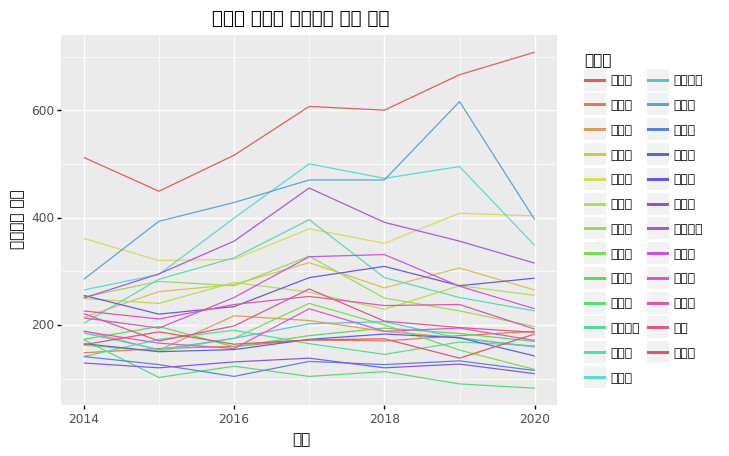

<ggplot: (8774564041692)>

In [15]:
from plotnine import*

fig = plt.figure()

(ggplot(GSC, aes(x="기간", y='강간추행 발생', group ='자치구', color = '자치구'))
+geom_line()
+ggtitle('기간별 자치구 강간추행 발생 추이'))

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

> 맥에서 matplot은 한글 문제가 해결이 되지만, ggplot은 한글 깨짐이 해결 안 됨 발견

- 이에 자치구명/X,Y축 이름을 모두 영어로 변경

In [17]:
GSC.loc[GSC['자치구'] =='강남구','자치구'] ='Gangnam'
GSC.loc[GSC['자치구'] =='강동구', '자치구'] ='Gangdong'
GSC.loc[GSC['자치구'] =='강북구', '자치구'] ='Gangbuk'
GSC.loc[GSC['자치구'] =='강서구', '자치구'] ='Gangseo'
GSC.loc[GSC['자치구'] =='관악구', '자치구'] ='Gwanak'
GSC.loc[GSC['자치구'] =='광진구', '자치구'] ='Gwangjin'
GSC.loc[GSC['자치구'] =='구로구', '자치구'] ='Guro'
GSC.loc[GSC['자치구'] =='금천구', '자치구'] ='Geumcheon'
GSC.loc[GSC['자치구'] =='노원구', '자치구'] ='Nowon'
GSC.loc[GSC['자치구'] =='도봉구', '자치구'] ='Dobong'
GSC.loc[GSC['자치구'] =='동대문구','자치구'] ='Dongdaemun'
GSC.loc[GSC['자치구'] =='동작구', '자치구'] ='Dongjak'
GSC.loc[GSC['자치구'] =='마포구', '자치구'] ='Mapo'
GSC.loc[GSC['자치구'] =='서대문구','자치구'] ='Seodaemun'
GSC.loc[GSC['자치구'] =='서초구', '자치구'] ='Seocho'
GSC.loc[GSC['자치구'] =='성동구', '자치구'] ='Sungdong'
GSC.loc[GSC['자치구'] =='성북구', '자치구'] ='Seongbuk'
GSC.loc[GSC['자치구'] =='송파구', '자치구'] ='Songpa'
GSC.loc[GSC['자치구'] =='양천구', '자치구'] ='Yangcheon'
GSC.loc[GSC['자치구'] =='영등포구', '자치구'] ='Yeongdeungpo'
GSC.loc[GSC['자치구'] =='용산구', '자치구'] ='Yongsan'
GSC.loc[GSC['자치구'] =='은평구', '자치구'] ='Eunpyeong'
GSC.loc[GSC['자치구'] =='종로구', '자치구'] ='Jongno'
GSC.loc[GSC['자치구'] =='중구', '자치구'] ='Jung'
GSC.loc[GSC['자치구'] =='중랑구', '자치구'] ='Jungnang'

In [18]:
GSC.rename(columns = {'기간':'Year'},inplace=True)
GSC.rename(columns = {'자치구':'City'},inplace=True)
GSC.rename(columns = {'강간추행 발생':'Occurrence'},inplace=True)
GSC.rename(columns = {'강간추행 검거':'Arrested'},inplace=True)

<Figure size 432x288 with 0 Axes>

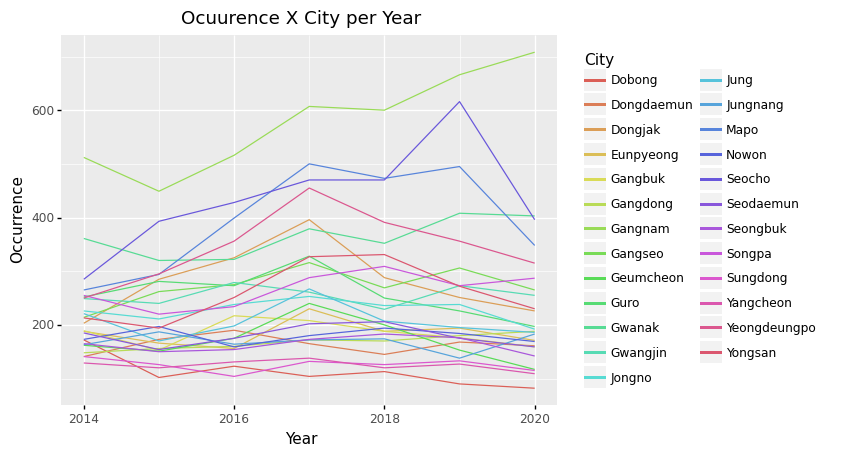

<ggplot: (8774552218676)>

In [19]:
from plotnine import*

fig = plt.figure()

(ggplot(GSC, aes(x="Year", y='Occurrence', group ='City', color = 'City'))
+geom_line()
+ggtitle('Ocuurence X City per Year'))

> 구별 강간범죄 추행 발생 수를 비교해보았을때, 특정 구가 모든 년도에서 최댓값을 가지는 것을 확인, 구가 많아서 색으로 구분이 어렵기 때문에 최댓값을 반환하도록 하여 범죄 발생 수가 많은 구를 식별

In [20]:
GSC1=GSC.loc[GSC.groupby(['Year'])['Occurrence'].idxmax()]

In [21]:
GSC1

,City,Year,Occurrence,Arrested
0,Gangnam,2014,512,403
1,Gangnam,2015,449,349
2,Gangnam,2016,516,413
3,Gangnam,2017,607,496
4,Gangnam,2018,600,523
5,Gangnam,2019,666,562
6,Gangnam,2020,708,627


## 분석 결과, 강남구가 모든 년도에 최대값을 가진다는 점을 확인

## 다음으로, 범죄 발생의 독립변수들을 알아내기 위하여, 서울시 전체를 대상으로 ‘발생장소별’ 현황 통계를 살펴보았다.

> 성폭력 범죄가 어떤 장소에서 주로 발생하는지 분석하기 위해, 
서울시 5대 범죄 발생장소별 현황 통계를 불러왔다.

In [22]:
Crime_5 = pd.read_excel('/Users/choohyunho/Desktop/머신러닝 팀플 최종/서울시 5대범죄 발생장소별 현황통계.xls')
# 출처: 서울시 5대 범죄 발생장소별 현황 통계
Crime_5

,기간,구분,계,아파트 연립다세대,단독주택,노상,상점,숙박업소목욕탕,유흥접객업소,사무실,역대합실,교통수단,유원지,학교,금융기관,기타
0,2014,계,130674,5671,7325,39067,5068,2320,5993,2940,874,2079,1057,679,1530,56071
1,2014,살인,158,22,36,33,-,8,6,9,-,1,1,-,-,42
2,2014,강도,343,37,36,92,45,10,17,11,2,1,5,-,-,87
3,2014,강간강제추행,5462,296,404,1007,102,471,364,127,144,694,48,26,1,1778
4,2014,절도,59393,2765,3655,11931,3988,1506,2452,1216,401,936,472,425,1482,28164
5,2014,폭력,65318,2551,3194,26004,933,325,3154,1577,327,447,531,228,47,26000
6,2015,계,126401,5039,6408,37548,4816,1638,5004,2458,843,2173,951,640,1322,57561
7,2015,살인,163,20,39,37,1,3,5,3,-,-,4,1,-,50
8,2015,강도,276,20,23,70,34,15,14,8,-,3,1,-,3,85
9,2015,강간강제추행,5449,283,346,924,73,395,342,91,181,812,51,46,1,1904


In [23]:
#범죄 발생 지역 비중을 확인하는 데에 무의미해보이는 컬럼인 구분'계','기타' 삭제

Crime_5=Crime_5.drop(['구분', '계','기타'], axis =1)

In [24]:
# 데이터 셋에서 연도별 성범죄(강간강제추행) 관련만 추출

Crime5 = Crime_5.loc[[3,9,15,21,27,33,39]]
Crime5

,기간,아파트 연립다세대,단독주택,노상,상점,숙박업소목욕탕,유흥접객업소,사무실,역대합실,교통수단,유원지,학교,금융기관
3,2014,296,404,1007,102,471,364,127,144,694,48,26,1
9,2015,283,346,924,73,395,342,91,181,812,51,46,1
15,2016,284,395,986,95,389,398,132,181,841,59,33,2
21,2017,319,413,1061,116,408,495,130,242,1105,51,49,1
27,2018,441,538,978,170,553,851,114,280,968,57,60,6
33,2019,533,552,946,178,528,968,128,255,966,54,49,3
39,2020,556,588,853,202,441,782,155,174,632,66,29,3


In [25]:
Crime5.set_index("기간", inplace = True)
Crime5

,아파트 연립다세대,단독주택,노상,상점,숙박업소목욕탕,유흥접객업소,사무실,역대합실,교통수단,유원지,학교,금융기관
기간,,,,,,,,,,,,
2014,296,404,1007,102,471,364,127,144,694,48,26,1
2015,283,346,924,73,395,342,91,181,812,51,46,1
2016,284,395,986,95,389,398,132,181,841,59,33,2
2017,319,413,1061,116,408,495,130,242,1105,51,49,1
2018,441,538,978,170,553,851,114,280,968,57,60,6
2019,533,552,946,178,528,968,128,255,966,54,49,3
2020,556,588,853,202,441,782,155,174,632,66,29,3


In [26]:
# 반복문을 활용하여 각 연도별 데이터 셋으로 분류
A = [2014,2015,2016,2017,2018,2019,2020]
for i in A :
    globals()['crime{}'.format(i)] = Crime5.loc[[i]]

In [27]:
# 파이차트 활용의 용이성을 위해 행렬 변환
crime2014= crime2014.transpose()
crime2015= crime2015.transpose()
crime2016= crime2016.transpose()
crime2017= crime2017.transpose()
crime2018= crime2018.transpose()
crime2019= crime2019.transpose()
crime2020= crime2020.transpose()

In [28]:
crime2014.head()

기간,2014
아파트 연립다세대,296
단독주택,404
노상,1007
상점,102
숙박업소목욕탕,471


> 파이차트를 활용하여 성범죄의 발생 장소의 비중을 확인! 

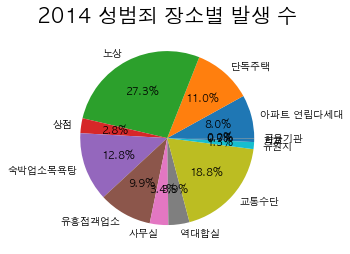

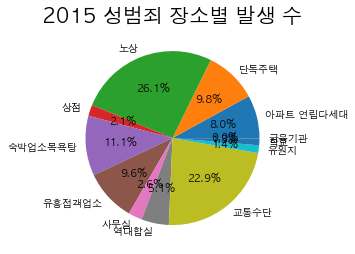

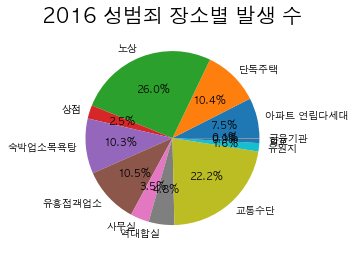

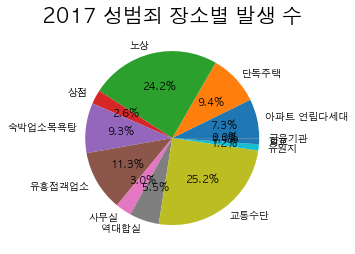

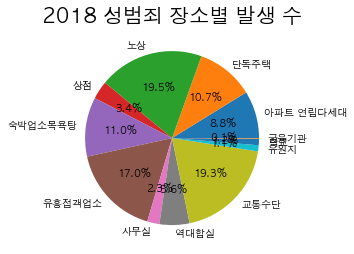

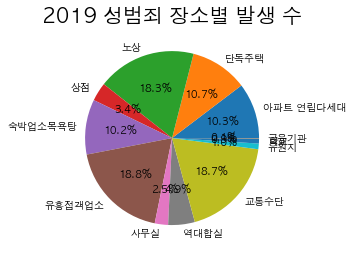

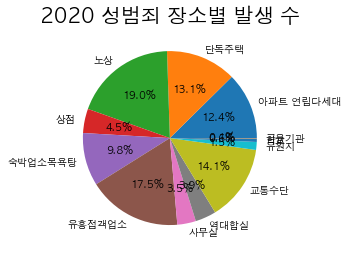

In [29]:

labels = ['아파트 연립다세대', '단독주택', '노상', '상점', '숙박업소목욕탕', '유흥접객업소', '사무실', '역대합실', '교통수단', '유원지', '학교', '금융기관']
plt.title('2014 성범죄 장소별 발생 수', size = 20)
plt.pie(crime2014[2014], labels = labels, autopct='%1.1f%%')
plt.show()


labels = ['아파트 연립다세대', '단독주택', '노상', '상점', '숙박업소목욕탕', '유흥접객업소', '사무실', '역대합실', '교통수단', '유원지', '학교', '금융기관']
plt.title('2015 성범죄 장소별 발생 수', size = 20)
plt.pie(crime2015[2015], labels = labels, autopct='%1.1f%%')
plt.show()


labels = ['아파트 연립다세대', '단독주택', '노상', '상점', '숙박업소목욕탕', '유흥접객업소', '사무실', '역대합실', '교통수단', '유원지', '학교', '금융기관']
plt.title('2016 성범죄 장소별 발생 수', size = 20)
plt.pie(crime2016[2016], labels = labels, autopct='%1.1f%%')
plt.show()



labels = ['아파트 연립다세대', '단독주택', '노상', '상점', '숙박업소목욕탕', '유흥접객업소', '사무실', '역대합실', '교통수단', '유원지', '학교', '금융기관']
plt.title('2017 성범죄 장소별 발생 수', size = 20)
plt.pie(crime2017[2017], labels = labels, autopct='%1.1f%%')
plt.show()



labels = ['아파트 연립다세대', '단독주택', '노상', '상점', '숙박업소목욕탕', '유흥접객업소', '사무실', '역대합실', '교통수단', '유원지', '학교', '금융기관']
plt.title('2018 성범죄 장소별 발생 수', size = 20)
plt.pie(crime2018[2018], labels = labels, autopct='%1.1f%%')
plt.show()



labels = ['아파트 연립다세대', '단독주택', '노상', '상점', '숙박업소목욕탕', '유흥접객업소', '사무실', '역대합실', '교통수단', '유원지', '학교', '금융기관']
plt.title('2019 성범죄 장소별 발생 수', size = 20)
plt.pie(crime2019[2019], labels = labels, autopct='%1.1f%%')
plt.show()


labels = ['아파트 연립다세대', '단독주택', '노상', '상점', '숙박업소목욕탕', '유흥접객업소', '사무실', '역대합실', '교통수단', '유원지', '학교', '금융기관']
plt.title('2020 성범죄 장소별 발생 수', size = 20)
plt.pie(crime2020[2020], labels = labels, autopct='%1.1f%%')
plt.show()



연도별 비율을 확인해보니.. 상위권 요소들을 추출
> 단독주택, 아파트, 노상, 유흥업소, 교통수단

- 그중 단독주택과 아파트는 주거공간이라는 특성을 공유하고 있으므로, 같은 변인으로 취급하기로 결정
- 교통수단에서 일어나는 성범죄는 지역에 한정하기 어려우며, 범죄 발생에 대한 시스템을 각 교통수단 운영사에서 자체적으로 관리하기 때문에 유의미한 변인 추출이 어려우며, 초기 프로젝트 방향과 무관하다고 생각해 제외하기로 결정





> 강남구 내의 성범죄가 가장 많이 발생하며 증가하는 추세임을 위에서 확인하였고,이러한 비율 변화에 어떤 요인들이 영향을 미칠지 강남구로 영역을 한정지어 심층 조사를 해보기로 결정

**주거공간, 노상, 유흥업소**  
이 장소들을 바탕으로 7개년도 구별 데이터셋을 도출  
**구별 유흥 단란 주점 수 / 안전 비상벨 / 여성안심귀가 스카우트 제도 / 구별 CCTV 신규 설치 수**

## 데이터셋을 독립변수로 활용하기 위한 전처리 과정 

## 독립변수 1 (구별 유흥 단란 주점 수)

In [30]:
df = pd.read_excel("/Users/choohyunho/Desktop/머신러닝 팀플 최종/서울시 식품위생업_2014-2020.xls", header = 1)
# 출처: 서울시 식품위생업 현황(구별) 통계 
df

,기간,자치구,합계,소계,휴게음식점,일반음식점,제과점,단란주점,유흥주점,위탁급식영업,...,식품첨가물 제조업,소계.2,식품운반업,식품판매업,식품보존업,용기·포장류제조업,소계.3,건강기능식품수입업,건강기능식품판매업,건강기능식품제조업
0,2014,계,215605,151588,24043,117721,3473,2919,2270,1162,...,13,17374,319,16957,7,91,26446,1483,24963,-
1,2014,종로구,9691,8480,1295,6648,114,136,224,63,...,-,90,-,89,-,1,706,80,626,-
2,2014,중구,10573,8154,1851,5719,145,101,257,81,...,-,661,4,624,-,33,1107,43,1064,-
3,2014,용산구,6349,4694,706,3716,76,121,35,40,...,-,592,2,586,-,4,587,19,568,-
4,2014,성동구,5272,3688,569,2920,86,53,24,36,...,-,569,4,549,-,16,477,22,455,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2020,관악구,8686,6512,1290,4804,134,78,189,17,...,2,418,5,412,-,1,947,-,947,-
178,2020,서초구,13049,8781,2257,6038,254,90,46,96,...,1,880,32,847,-,1,2272,-,2272,-
179,2020,강남구,23239,16956,3918,12052,431,224,178,153,...,1,1390,15,1374,1,-,3359,-,3359,-
180,2020,송파구,15499,10151,2446,7146,242,145,93,79,...,3,1229,92,1130,5,2,2140,-,2140,-


In [31]:
sulzip = df[['기간', '자치구', '단란주점', '유흥주점']]
sulzip

,기간,자치구,단란주점,유흥주점
0,2014,계,2919,2270
1,2014,종로구,136,224
2,2014,중구,101,257
3,2014,용산구,121,35
4,2014,성동구,53,24
...,...,...,...,...
177,2020,관악구,78,189
178,2020,서초구,90,46
179,2020,강남구,224,178
180,2020,송파구,145,93


In [32]:
sulzip = df[['기간', '자치구', '단란주점', '유흥주점']]
sulzip

,기간,자치구,단란주점,유흥주점
0,2014,계,2919,2270
1,2014,종로구,136,224
2,2014,중구,101,257
3,2014,용산구,121,35
4,2014,성동구,53,24
...,...,...,...,...
177,2020,관악구,78,189
178,2020,서초구,90,46
179,2020,강남구,224,178
180,2020,송파구,145,93


In [33]:
sulzip['단란+유흥'] = sulzip['단란주점']+sulzip['유흥주점']

In [34]:
sulzip = sulzip[['기간', '자치구', '단란+유흥']]
sulzip

,기간,자치구,단란+유흥
0,2014,계,5189
1,2014,종로구,360
2,2014,중구,358
3,2014,용산구,156
4,2014,성동구,77
...,...,...,...
177,2020,관악구,267
178,2020,서초구,136
179,2020,강남구,402
180,2020,송파구,238


In [35]:
Grouped_Sulzip = sulzip.groupby(['자치구', '기간'],as_index=False).mean()
Grouped_Sulzip

,자치구,기간,단란+유흥
0,강남구,2014,604
1,강남구,2015,582
2,강남구,2016,556
3,강남구,2017,520
4,강남구,2018,477
...,...,...,...
177,중랑구,2016,131
178,중랑구,2017,130
179,중랑구,2018,127
180,중랑구,2019,122


In [36]:
# 강남구 분석용
GNsulzip = Grouped_Sulzip.loc[[0,1,2,3,4,5,6]]

## 독립변수 2 (안전 비상벨)

In [37]:
bell = pd.read_csv("/Users/choohyunho/Desktop/머신러닝 팀플 최종/전국안전비상벨위치표준데이터.csv", encoding = 'cp949')
# 출처: 전국 안전비상벨 위치 표준 데이터
bell.columns

Index(['안전비상벨관리번호', '설치목적', '설치장소유형', '설치위치', '소재지도로명주소', '소재지지번주소', '위도',
       '경도', '연계방식', '경찰연계유무', '경비업체연계유무', '관리사무소연계유무', '부가기능', '안전비상벨설치년도',
       '최종점검일자', '최종점검결과구분', '관리기관명', '관리기관전화번호', '데이터기준일자', '제공기관코드',
       '제공기관명'],
      dtype='object')

In [38]:
#전국비상벨 위치데이터를 사용하였기 때문에 서울시내 설치된 비상벨 위치데이터만 필터링
bell = bell[bell['제공기관명'].str.contains('서울')]
#서울시내 자치구별 비상벨 위치를 표시하기 위해 새로운 컬럼 생성
bell['자치구'] = bell['제공기관명'].str.slice(start=6, stop=9)
bell

,안전비상벨관리번호,설치목적,설치장소유형,설치위치,소재지도로명주소,소재지지번주소,위도,경도,연계방식,경찰연계유무,...,부가기능,안전비상벨설치년도,최종점검일자,최종점검결과구분,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명,자치구
0,목3,1,1,CCTV 폴대,서울특별시 양천구 목동로210,서울특별시 양천구 목동 810-1,37.527346,126.864459,3,N,...,NaN,2006,2020-05-20,Y,양천구청,02-2620-4793,2020-05-20,3140000,서울특별시 양천구,양천구
1,116038,1,5,서울특별시 강서구 염창동 271,서울특별시 강서구 공항대로61길 42,서울특별시 강서구 염창동 271,37.552726,126.866383,3,Y,...,NaN,2013,2020-05-19,Y,서울특별시 강서구청 스마트도시과,02-2600-1882,2020-05-21,3150000,서울특별시 강서구,강서구
2,232011,1,5,서울특별시 강서구 염창동 245-1,서울특별시 강서구 양천로67가길 63,서울특별시 강서구 염창동 53-1,37.553772,126.870967,3,Y,...,NaN,2015,2020-05-19,Y,서울특별시 강서구청 스마트도시과,02-2600-1882,2020-05-21,3150000,서울특별시 강서구,강서구
3,242001,1,5,서울특별시 강서구 우장산동 우장초등학교,서울특별시 강서구 화곡로 263,서울특별시 강서구 화곡동 18-5,37.549637,126.845983,3,Y,...,NaN,2016,2020-05-19,Y,서울특별시 강서구청 스마트도시과,02-2600-1882,2020-05-21,3150000,서울특별시 강서구,강서구
4,113009,1,5,서울특별시 강서구 발산1동 발산초등학교,서울특별시 강서구 강서로46길 23,서울특별시 강서구 내발산동 707,37.550881,126.838163,3,Y,...,NaN,2013,2020-05-19,Y,서울특별시 강서구청 스마트도시과,02-2600-1882,2020-05-21,3150000,서울특별시 강서구,강서구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25693,공중화장실-2호,1,2,구기동공중화장실,서울특별시 종로구 비봉길 13,NaN,37.609572,126.956417,3,Y,...,NaN,2017,2020-06-04,Y,종로구청 청소행정과,02-2148-2383,2020-07-10,3000000,서울특별시 종로구,종로구
25694,공중화장실-1호,1,2,삼청동공중화장실,서울특별시 종로구 삼청로 117,NaN,37.585877,126.981655,3,Y,...,NaN,2017,2020-06-04,Y,종로구청 청소행정과,02-2148-2383,2020-07-10,3000000,서울특별시 종로구,종로구
25726,62,1,99,출입문 옆(해방교회 아래쪽),서울특별시 용산구 신흥로15길 20,서울특별시 용산구 용산동2가 31-2,37.544129,126.985711,3,N,...,CCTV,2010,2019-12-31,Y,용산구청,02-2199-6660,2020-10-16,3020000,서울특별시 용산구,용산구
25756,61,1,99,신흥교회 뒤쪽 거주자주차구역,서울특별시 용산구 신흥로 120,서울특별시 용산구 용산동2가 1-1599,37.544767,126.982614,3,N,...,CCTV,2010,2019-12-31,Y,용산구청,02-2199-6660,2020-10-16,3020000,서울특별시 용산구,용산구


In [39]:
# 안심벨 위치 데이터 결측치 확인
bell['제공기관명'].isnull().sum()

0

In [40]:
bell = bell[['자치구', '안전비상벨설치년도', '설치위치', '소재지도로명주소','소재지지번주소']]
bell

,자치구,안전비상벨설치년도,설치위치,소재지도로명주소,소재지지번주소
0,양천구,2006,CCTV 폴대,서울특별시 양천구 목동로210,서울특별시 양천구 목동 810-1
1,강서구,2013,서울특별시 강서구 염창동 271,서울특별시 강서구 공항대로61길 42,서울특별시 강서구 염창동 271
2,강서구,2015,서울특별시 강서구 염창동 245-1,서울특별시 강서구 양천로67가길 63,서울특별시 강서구 염창동 53-1
3,강서구,2016,서울특별시 강서구 우장산동 우장초등학교,서울특별시 강서구 화곡로 263,서울특별시 강서구 화곡동 18-5
4,강서구,2013,서울특별시 강서구 발산1동 발산초등학교,서울특별시 강서구 강서로46길 23,서울특별시 강서구 내발산동 707
...,...,...,...,...,...
25693,종로구,2017,구기동공중화장실,서울특별시 종로구 비봉길 13,NaN
25694,종로구,2017,삼청동공중화장실,서울특별시 종로구 삼청로 117,NaN
25726,용산구,2010,출입문 옆(해방교회 아래쪽),서울특별시 용산구 신흥로15길 20,서울특별시 용산구 용산동2가 31-2
25756,용산구,2010,신흥교회 뒤쪽 거주자주차구역,서울특별시 용산구 신흥로 120,서울특별시 용산구 용산동2가 1-1599


In [41]:
bell2 = pd.read_csv("/Users/choohyunho/Desktop/머신러닝 팀플 최종/비상벨.csv", encoding= 'cp949')
# 전국 안전비상벨 위치 표준 데이터를 가공한 데이터
bell2 = bell2[['자치구', '안전비상벨설치년도']]
bell2

,자치구,안전비상벨설치년도
0,양천구,2006
1,강서구,2013
2,강서구,2015
3,강서구,2016
4,강서구,2013
...,...,...
9113,종로구,2017
9114,종로구,2017
9115,용산구,2010
9116,용산구,2010


In [42]:
bell2.dtypes

자치구          object
안전비상벨설치년도     int64
dtype: object

In [43]:
bell2["설치대 수"]= 1
bell2

,자치구,안전비상벨설치년도,설치대 수
0,양천구,2006,1
1,강서구,2013,1
2,강서구,2015,1
3,강서구,2016,1
4,강서구,2013,1
...,...,...,...
9113,종로구,2017,1
9114,종로구,2017,1
9115,용산구,2010,1
9116,용산구,2010,1


In [44]:
pd.set_option('display.max_rows', None)

In [45]:
Grouped_bell = bell2.groupby(['자치구', '안전비상벨설치년도'],as_index=False).sum()
Grouped_bell

,자치구,안전비상벨설치년도,설치대 수
0,강남구,2016,37
1,강남구,2017,2
2,강남구,2019,1
3,강동구,2014,28
4,강동구,2015,189
5,강동구,2016,84
6,강동구,2017,97
7,강동구,2018,84
8,강동구,2019,18
9,강북구,2016,4


In [46]:
index_year = Grouped_bell[Grouped_bell['안전비상벨설치년도'] < 2014].index
index_year

Int64Index([ 11,  12,  17,  18,  19,  20,  21,  22,  30,  31,  32,  33,  34,
             35,  36,  37,  50,  59,  60,  61,  62,  70,  71,  72,  73,  74,
             75,  76,  81,  82,  83,  84,  85,  86,  87,  96,  97,  98,  99,
            100, 101, 108, 109, 110, 111, 112, 113, 114, 121, 122, 123, 124,
            125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 144, 145,
            146, 147, 148, 154, 155, 156, 157, 158, 159, 166, 171, 172, 173,
            174, 175, 176, 177],
           dtype='int64')

In [47]:
Bell = Grouped_bell.drop(index_year)
Bell

,자치구,안전비상벨설치년도,설치대 수
0,강남구,2016,37
1,강남구,2017,2
2,강남구,2019,1
3,강동구,2014,28
4,강동구,2015,189
5,강동구,2016,84
6,강동구,2017,97
7,강동구,2018,84
8,강동구,2019,18
9,강북구,2016,4


In [48]:
Bell.reset_index(inplace = True)
Bell

,index,자치구,안전비상벨설치년도,설치대 수
0,0,강남구,2016,37
1,1,강남구,2017,2
2,2,강남구,2019,1
3,3,강동구,2014,28
4,4,강동구,2015,189
5,5,강동구,2016,84
6,6,강동구,2017,97
7,7,강동구,2018,84
8,8,강동구,2019,18
9,9,강북구,2016,4


In [49]:
Bell.to_excel('Bell.xlsx')

In [50]:
Bell = pd.read_excel('/Users/choohyunho/Desktop/머신러닝 팀플 최종/Bell_1420.xlsx')
# 출처: 전국 안전비상벨 위치 표준 데이터를 가공한 데이터
Bell

,Unnamed: 0,자치구,기간,비상벨 수
0,0,강남구,2014,0
1,1,강남구,2015,0
2,2,강남구,2016,37
3,3,강남구,2017,39
4,4,강남구,2018,39
5,5,강남구,2019,40
6,6,강남구,2020,40
7,7,강동구,2014,28
8,8,강동구,2015,217
9,9,강동구,2016,301


In [51]:
Bell = Bell.drop(['Unnamed: 0'], axis = 1)
Bell

,자치구,기간,비상벨 수
0,강남구,2014,0
1,강남구,2015,0
2,강남구,2016,37
3,강남구,2017,39
4,강남구,2018,39
5,강남구,2019,40
6,강남구,2020,40
7,강동구,2014,28
8,강동구,2015,217
9,강동구,2016,301


## 독립변수 3 (여성안심귀가 스카우트 제도)

In [52]:
#여성안심귀가 스카우터 2015년도부터 정식 시행, 각 연도별 출동횟수
Scouter = pd.read_excel("/Users/choohyunho/Desktop/머신러닝 팀플 최종/서울시 여성안심스카우트 이용현황(2015_2020) (1).xlsx")
# 출처: 서울시 여성 안심 스카우트 이용현황 
Scouter

,자치구,2014,2015,2016,2017,2018,2019,2020
0,종로구,0,8861,6970,3789,1438,10097,11445
1,중구,0,2935,4901,11110,11931,12658,8861
2,용산구,0,4994,6355,8461,8979,9238,5749
3,성동구,0,8043,13170,18766,19584,17510,10872
4,광진구,0,6533,5990,6183,6206,6099,3215
5,동대문구,0,5588,7259,13704,15771,20776,19420
6,중랑구,0,8448,7815,8001,10163,14696,8015
7,성북구,0,6789,7600,13486,14427,16836,7220
8,강북구,0,10507,13833,17368,18446,18282,10573
9,도봉구,0,3467,4800,11499,10491,12602,7092


In [53]:
Scouter.dtypes
#강남구 스카우터 수
GN_Scouter=Scouter.loc[[22]]

## 독립변수 4 (구별 CCTV 증감 수)

In [54]:
#서울시 자치구 연도별 CCTV 증감 
CCTV = pd.read_csv("/Users/choohyunho/Desktop/머신러닝 팀플 최종/CCTV1.csv")
# 출처: 서울시 자치구 년도별 CCTV 설치 현황 
CCTV

,Unnamed: 0,2014년,2015년,2016년,2017년,2018년,2019년,2020년
0,종로구,210,150,1,261,85,9,200
1,중구,77,236,240,372,386,155,361
2,용산구,125,221,298,351,125,307,617
3,성동구,105,339,310,874,390,262,461
4,광진구,187,98,52,675,465,712,175
5,동대문구,29,111,233,136,197,209,223
6,중랑구,88,141,161,162,173,1049,939
7,성북구,230,323,594,460,867,714,251
8,강북구,65,105,243,6,392,1000,588
9,도봉구,181,79,159,134,222,198,168


In [55]:
#강남구 CCTV 증감
GN_CCTV=CCTV.loc[[22]]
GN_CCTV

,Unnamed: 0,2014년,2015년,2016년,2017년,2018년,2019년,2020년
22,강남구,597,840,1310,999,748,789,942


# 2-2. 강남구만 선형회귀
> 전체적인 선형회귀 분석을 진행하기 전, 범죄 수가 가장 높은 강남구만 국소적으로 분석을 진행해보았다

In [56]:
Total = pd.read_excel("/Users/choohyunho/Desktop/머신러닝 팀플 최종/강남 데이터 통합2.xlsx")
# 출처: 강남구의 연도별 각 변인 데이터를 엑셀로 합친 데이터
Total = Total[['연도','CCTV 증감', '스카우트 호출 횟수', '유흥 단란 주점 수','비상벨 수','Ocurrence']]
Total

,연도,CCTV 증감,스카우트 호출 횟수,유흥 단란 주점 수,비상벨 수,Ocurrence
0,2014,597,0,604,0,512
1,2015,840,3341,582,0,449
2,2016,1310,2448,556,37,516
3,2017,999,6863,520,39,607
4,2018,748,8793,477,39,600
5,2019,789,6306,448,40,666
6,2020,942,5191,402,40,708


In [57]:
X = pd.DataFrame(Total, columns=['CCTV 증감', '스카우트 호출 횟수', '유흥 단란 주점 수','비상벨 수'])
Y = pd.DataFrame(Total, columns=['Ocurrence'])


In [58]:
from sklearn.model_selection import train_test_split

In [59]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [60]:
# intercept 추가
X = sm.add_constant(X, has_constant='add')
X.head()

,const,CCTV 증감,스카우트 호출 횟수,유흥 단란 주점 수,비상벨 수
0,1.0,597,0,604,0
1,1.0,840,3341,582,0
2,1.0,1310,2448,556,37
3,1.0,999,6863,520,39
4,1.0,748,8793,477,39


In [61]:
# 학습 데이터, 테스트 데이터 분리
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=6/7, test_size=1/7, random_state=1234)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(6, 5) (1, 5) (6, 1) (1, 1)


In [62]:
lm = sm.OLS(Y_train, X_train)
lm_train = lm.fit()

In [63]:
lm_train.summary()

/Users/choohyunho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ocurrence   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     6583.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):            0.00924
Time:                        18:01:00   Log-Likelihood:                -4.8152
No. Observations:                   6   AIC:                             19.63
Df Residuals:                       1   BIC:                             18.59
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        842.0805     10.437     80.680      0.008     709.462     974.699
CCTV 증감       -0.0333      0.005     -6.757      0.094      -0.096       0.029
스카우트 호출 횟수    -0.0197      0.000    -50.043      0.013      -0.025      -0.015
유흥 단란 주점 수    -0.5140      0.017    -30.920      0.021      -0.725      -0.303
비상벨 수          5.1376      0.092     55.828      0.011       3.968       6.307
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.502
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.915
Skew:                          -0.939   Prob(JB):                        0.633
Kurtosis:                       2.635   Cond. No.                     1.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 분석
해당 변인들이 유효한지 테스트하기 위해 성폭력 범죄 비율이 가장 높은 강남구 7개년 데이터로 선형 회귀를 시행했다.

* 분석에 앞서 모형의 Prob(F-statistic)이 0.05이하라면 유의미하고 R-squared가 0.2이면 사회과학에서 정확도가 높다는 점을 확인

이 선형회귀는 Prob(F-statistic)의 결과가 유의미하고, R-Squared 값이 1이지만 근본적으로 **데이터셋이 너무 작다**는 오류가 있다.

* R-Squared값이 1이라는 점(정확도 100%)이 애초에 무의미
* 오류: 유의미한 선형회귀를 진행하기 위해서는 적어도 8개의 트레이닝 세트가 필요함

# 2-3. 본격적 선형회귀에 앞서 데이터 전처리

## 7개년도 모든 구별 종속변수(서울시 강간추행 발생 수)

In [64]:
LR_SC

,자치구,기간,강간추행 발생,강간추행 검거
0,강남구,2014,512,403
1,강남구,2015,449,349
2,강남구,2016,516,413
3,강남구,2017,607,496
4,강남구,2018,600,523
5,강남구,2019,666,562
6,강남구,2020,708,627
7,강동구,2014,148,129
8,강동구,2015,156,123
9,강동구,2016,160,152


In [65]:
# 검거 수는 무의미 함을 위해서 확인, 발생수를 기준으로 선형 회귀 분석을 진행
LR_SC = LR_SC.drop(["강간추행 검거"], axis = 1)

In [66]:
LR_SC

,자치구,기간,강간추행 발생
0,강남구,2014,512
1,강남구,2015,449
2,강남구,2016,516
3,강남구,2017,607
4,강남구,2018,600
5,강남구,2019,666
6,강남구,2020,708
7,강동구,2014,148
8,강동구,2015,156
9,강동구,2016,160


## 7개년도 모든 구별 독립변수1 (단란 유흥 주점 수)

In [67]:
Grouped_Sulzip

,자치구,기간,단란+유흥
0,강남구,2014,604
1,강남구,2015,582
2,강남구,2016,556
3,강남구,2017,520
4,강남구,2018,477
5,강남구,2019,448
6,강남구,2020,402
7,강동구,2014,256
8,강동구,2015,250
9,강동구,2016,214


In [68]:
#유흥 주점 수에서 필요없는 로우인 '계' 를 삭제
idx = Grouped_Sulzip[Grouped_Sulzip['자치구']=='계'].index
Grouped_Sulzip.drop(idx, inplace = True)

In [69]:
LR_Bar=Grouped_Sulzip
LR_Bar

,자치구,기간,단란+유흥
0,강남구,2014,604
1,강남구,2015,582
2,강남구,2016,556
3,강남구,2017,520
4,강남구,2018,477
5,강남구,2019,448
6,강남구,2020,402
7,강동구,2014,256
8,강동구,2015,250
9,강동구,2016,214


In [70]:
LR_Bar.reset_index(inplace = True)

In [71]:
LR_Bar = LR_Bar.drop(['index'], axis=1)
LR_Bar

,자치구,기간,단란+유흥
0,강남구,2014,604
1,강남구,2015,582
2,강남구,2016,556
3,강남구,2017,520
4,강남구,2018,477
5,강남구,2019,448
6,강남구,2020,402
7,강동구,2014,256
8,강동구,2015,250
9,강동구,2016,214


## 7개년도 모든 구별 독립변수2 (CCTV 증감 수)

In [72]:
CCTV.set_index('Unnamed: 0', inplace = True)

In [73]:
CCTV_unstack = CCTV.unstack().reset_index()
CCTV_unstack

,level_0,Unnamed: 0,0
0,2014년,종로구,210
1,2014년,중구,77
2,2014년,용산구,125
3,2014년,성동구,105
4,2014년,광진구,187
5,2014년,동대문구,29
6,2014년,중랑구,88
7,2014년,성북구,230
8,2014년,강북구,65
9,2014년,도봉구,181


In [74]:
CCTV_unstack.columns = ['기간','자치구','설치 증감 수']
CCTV1=CCTV_unstack[['자치구','기간','설치 증감 수']]
CCTV1

,자치구,기간,설치 증감 수
0,종로구,2014년,210
1,중구,2014년,77
2,용산구,2014년,125
3,성동구,2014년,105
4,광진구,2014년,187
5,동대문구,2014년,29
6,중랑구,2014년,88
7,성북구,2014년,230
8,강북구,2014년,65
9,도봉구,2014년,181


In [75]:
CCTV2=CCTV1.sort_values(by=['자치구','기간'], ascending = True)
CCTV2

,자치구,기간,설치 증감 수
22,강남구,2014년,597
47,강남구,2015년,840
72,강남구,2016년,1310
97,강남구,2017년,999
122,강남구,2018년,748
147,강남구,2019년,789
172,강남구,2020년,942
24,강동구,2014년,49
49,강동구,2015년,154
74,강동구,2016년,202


In [76]:
CCTV2.reset_index(inplace = True)

In [77]:
CCTV2

,index,자치구,기간,설치 증감 수
0,22,강남구,2014년,597
1,47,강남구,2015년,840
2,72,강남구,2016년,1310
3,97,강남구,2017년,999
4,122,강남구,2018년,748
5,147,강남구,2019년,789
6,172,강남구,2020년,942
7,24,강동구,2014년,49
8,49,강동구,2015년,154
9,74,강동구,2016년,202


In [78]:
LR_CCTV=CCTV2[['자치구','기간','설치 증감 수']]

In [79]:
LR_CCTV['기간']=LR_CCTV['기간'].str.strip("년")
LR_CCTV = LR_CCTV.astype({'기간':int})
LR_CCTV.tail(20)

,자치구,기간,설치 증감 수
155,종로구,2015,150
156,종로구,2016,1
157,종로구,2017,261
158,종로구,2018,85
159,종로구,2019,9
160,종로구,2020,200
161,중구,2014,77
162,중구,2015,236
163,중구,2016,240
164,중구,2017,372


In [80]:
LR_CCTV['설치 증감 수'] = pd.to_numeric(LR_CCTV['설치 증감 수'],errors = 'coerce')
LR_CCTV.dtypes

자치구         object
기간           int64
설치 증감 수    float64
dtype: object

In [81]:
#원인을 찾을 수 없는 불용치를 데이터 원본을 보고 보충
LR_CCTV = LR_CCTV.replace(np.nan,1213)

In [82]:
LR_CCTV["설치 증감 수"] = LR_CCTV["설치 증감 수"].astype(int)
LR_CCTV.dtypes

자치구        object
기간          int64
설치 증감 수     int64
dtype: object

## 7개년도 모든 구별 독립변수3 (안심 스카우터 호출 횟수)


In [83]:
#스카우터 데이터 셋 불러오기
Scouter.set_index('자치구', inplace = True)
Scouter_unstack = Scouter.unstack().reset_index()
Scouter_unstack

,level_0,자치구,0
0,2014,종로구,0
1,2014,중구,0
2,2014,용산구,0
3,2014,성동구,0
4,2014,광진구,0
5,2014,동대문구,0
6,2014,중랑구,0
7,2014,성북구,0
8,2014,강북구,0
9,2014,도봉구,0


In [84]:
Scouter1 = Scouter_unstack.rename(columns={'level_0': '기간'})
Scouter1

,기간,자치구,0
0,2014,종로구,0
1,2014,중구,0
2,2014,용산구,0
3,2014,성동구,0
4,2014,광진구,0
5,2014,동대문구,0
6,2014,중랑구,0
7,2014,성북구,0
8,2014,강북구,0
9,2014,도봉구,0


In [85]:
Scouter2 = Scouter1.rename(columns={0: '스카우트 호출 횟수'})
Scouter2

,기간,자치구,스카우트 호출 횟수
0,2014,종로구,0
1,2014,중구,0
2,2014,용산구,0
3,2014,성동구,0
4,2014,광진구,0
5,2014,동대문구,0
6,2014,중랑구,0
7,2014,성북구,0
8,2014,강북구,0
9,2014,도봉구,0


In [86]:
Scouter3 = Scouter2[['자치구','기간','스카우트 호출 횟수']]
Scouter3

,자치구,기간,스카우트 호출 횟수
0,종로구,2014,0
1,중구,2014,0
2,용산구,2014,0
3,성동구,2014,0
4,광진구,2014,0
5,동대문구,2014,0
6,중랑구,2014,0
7,성북구,2014,0
8,강북구,2014,0
9,도봉구,2014,0


In [87]:
Scouter4=Scouter3.sort_values(by=['자치구','기간'], ascending = True)
Scouter4

,자치구,기간,스카우트 호출 횟수
22,강남구,2014,0
47,강남구,2015,3341
72,강남구,2016,2448
97,강남구,2017,6863
122,강남구,2018,8793
147,강남구,2019,6306
172,강남구,2020,5191
24,강동구,2014,0
49,강동구,2015,12797
74,강동구,2016,15910


In [88]:
Scouter4.reset_index(inplace = True)
Scouter4

,index,자치구,기간,스카우트 호출 횟수
0,22,강남구,2014,0
1,47,강남구,2015,3341
2,72,강남구,2016,2448
3,97,강남구,2017,6863
4,122,강남구,2018,8793
5,147,강남구,2019,6306
6,172,강남구,2020,5191
7,24,강동구,2014,0
8,49,강동구,2015,12797
9,74,강동구,2016,15910


In [89]:
LR_Scouter=Scouter4[['자치구','기간','스카우트 호출 횟수']]
LR_Scouter.tail(20)

,자치구,기간,스카우트 호출 횟수
155,종로구,2015,8861
156,종로구,2016,6970
157,종로구,2017,3789
158,종로구,2018,1438
159,종로구,2019,10097
160,종로구,2020,11445
161,중구,2014,0
162,중구,2015,2935
163,중구,2016,4901
164,중구,2017,11110


## 7개년도 모든 구별 독립변수4 (안심벨)

- 연도별 신규 설치 수를 각 연도별 설치 댓수로 엑셀 파일상에서 치환

In [90]:
Bell

,자치구,기간,비상벨 수
0,강남구,2014,0
1,강남구,2015,0
2,강남구,2016,37
3,강남구,2017,39
4,강남구,2018,39
5,강남구,2019,40
6,강남구,2020,40
7,강동구,2014,28
8,강동구,2015,217
9,강동구,2016,301


### 7개년도 모든 구 독립변수와 종속변수의 데이터 프레임 명 정리

### X
- LR_Scouter
- LR_CCTV
- LR_Bar
- Bell

### Y
- LR_SC

In [91]:
X = pd.merge(left = LR_Scouter, right = LR_CCTV, how = 'left', on = ['자치구', '기간'], sort = False)
X = pd.merge(left = X, right = LR_Bar, how = 'left', on = ['자치구', '기간'], sort = False)
X = pd.merge(left = X, right = Bell, how = 'left', on = ['자치구', '기간'], sort = False)

In [92]:
X.head(175)

,자치구,기간,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
0,강남구,2014,0,597,604,0
1,강남구,2015,3341,840,582,0
2,강남구,2016,2448,1310,556,37
3,강남구,2017,6863,999,520,39
4,강남구,2018,8793,748,477,39
5,강남구,2019,6306,789,448,40
6,강남구,2020,5191,942,402,40
7,강동구,2014,0,49,256,28
8,강동구,2015,12797,154,250,217
9,강동구,2016,15910,202,214,301


In [93]:
X_origin = X

In [94]:
Y = Grouped_SC.groupby(['자치구', '기간'],as_index=False).mean()
Y = Y.drop(index=[175,176,177,178,179,180,181], axis=0)
condition = (Y['기간'] == 2020)
Y = Y[condition]
Y = pd.DataFrame(Y, columns=['강간추행 발생'])
Y

,강간추행 발생
6,708
13,188
20,159
27,265
34,403
41,255
48,197
55,117
62,169
69,82


In [95]:
Y.reset_index(inplace = True)
Y_2020=Y[['강간추행 발생']]
Y_2020

,강간추행 발생
0,708
1,188
2,159
3,265
4,403
5,255
6,197
7,117
8,169
9,82


# 2-4. 모든 연도 모든 구 선형회귀 + KNN 비교
> 선형 회귀 분석 표본을 늘리기 위해 모든 연도 모든 구 데이터로 선형 회귀와 KNN 분석을 진행하고 각 방법론을 비교해보았다.

In [96]:
Y = LR_SC[['강간추행 발생']]

In [97]:
X=X.drop(['자치구','기간'], axis=1)
X

,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
0,0,597,604,0
1,3341,840,582,0
2,2448,1310,556,37
3,6863,999,520,39
4,8793,748,477,39
5,6306,789,448,40
6,5191,942,402,40
7,0,49,256,28
8,12797,154,250,217
9,15910,202,214,301


In [98]:
# intercept 추가
X = sm.add_constant(X, has_constant='add')
X.head()

,const,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
0,1.0,0,597,604,0
1,1.0,3341,840,582,0
2,1.0,2448,1310,556,37
3,1.0,6863,999,520,39
4,1.0,8793,748,477,39


In [99]:
X.shape

(175, 5)

In [100]:
Y.shape

(175, 1)

In [101]:
# 학습 데이터, 테스트 데이터 분리
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=1234)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(122, 5) (53, 5) (122, 1) (53, 1)


In [102]:
X.dtypes

const         float64
스카우트 호출 횟수      int64
설치 증감 수         int64
단란+유흥           int64
비상벨 수           int64
dtype: object

In [103]:
# 회귀 모델 생성
lm = sm.OLS(Y_train, X_train)
lm_train = lm.fit()

In [104]:
lm_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                강간추행 발생   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     21.27
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           3.35e-13
Time:                        18:01:00   Log-Likelihood:                -720.83
No. Observations:                 122   AIC:                             1452.
Df Residuals:                     117   BIC:                             1466.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.5600     22.904      2.775      0.006      18.199     108.921
스카우트 호출 횟수     0.0021      0.001      1.593      0.114      -0.001       0.005
설치 증감 수        0.0737      0.034      2.197      0.030       0.007       0.140
단란+유흥          0.5870      0.079      7.400      0.000       0.430       0.744
비상벨 수          0.1406      0.050      2.802      0.006       0.041       0.240
==============================================================================
Omnibus:                       25.626   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.139
Skew:                           1.101   Prob(JB):                     2.34e-08
Kurtosis:                       4.437   Cond. No.                     3.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 분석

* 데이터셋을 늘리기 위해 2014-2020년도 모든 구가 독립적이라는 가정 하에 선형회귀를 진행했지만 타임시리즈 데이터는 시간변수의 correlation을 고래했을 때 선형회귀에 적합하지 않은 데이터이다.

### 그러나 타임시리즈를 포함하고도 F-statistic의 P-value와 R-squared의 수치를 보아 유의미한 결과가 나왔으며 이대로 머신러닝을 진행해도 괜찮겠다는 판단

## KNN과 비교
### 해당 데이터셋과 변인이 유효하다고 가정한 상태로 KNN과 성능비교까지 진행한 후에, 25개구의 2020년 데이터에 대해서만 온전한 선형 회귀분석을 진행하기로 결정하였다.

In [105]:
Y_predict = lm_train.predict(X_test)
print(Y_predict)

54     271.821809
58     150.945522
25     338.719544
172    202.187519
138    333.844795
102    335.682092
74     212.041742
134    387.173705
101    349.684872
149    278.051495
29     340.950692
31     357.383263
155    304.114957
137    375.077856
135    379.237977
88     228.016727
39     242.474080
99     276.902532
125    320.665332
105    116.500144
162    290.866436
110    157.895538
51     191.901149
6      385.584057
63     136.305294
40     255.754607
136    380.895032
111    157.925341
160    287.096111
59     151.512555
9      280.076748
61     155.337593
27     319.001215
57     161.341402
150    267.423567
32     354.389739
121    271.676447
91     131.274689
48     186.992736
141    197.482557
11     326.055781
159    279.559516
151    292.133168
17     221.567879
145    220.726395
77     181.817080
117    229.555551
35     140.741506
20     224.248935
131    145.966184
95     176.904253
93     165.740379
42     166.417825
dtype: float64


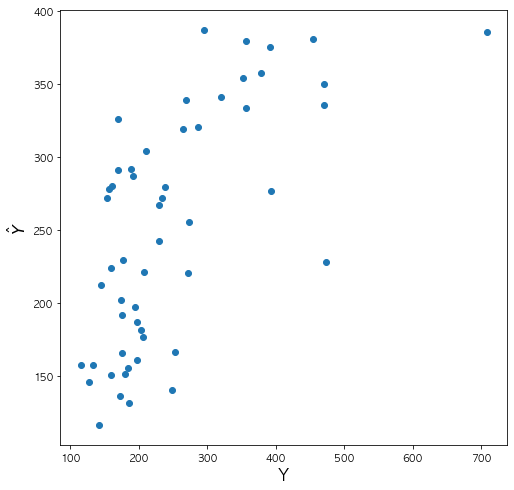

In [106]:
plt.figure(figsize=(8, 8))
plt.scatter(Y_test, Y_predict)
plt.xlabel('Y', size=16)
plt.ylabel('$\hat{Y}$', size=16)
plt.show()

In [107]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [108]:
# MSE(mean squared error), R-squared (모형 성능 확인)
mae = mean_absolute_error(Y_test, Y_predict)
mse = mean_squared_error(Y_test, Y_predict)
rmse = np.sqrt(mse)
r_square = r2_score(Y_test, Y_predict)
print('MAE : {0:.3f}'.format(mae))
print('MSE : {0:.3f}'.format(mse))
print('RMSE : {0:.3f}'.format(rmse))
print('R-square : {0:.3f}'.format(r_square))

MAE : 62.451
MSE : 7502.665
RMSE : 86.618
R-square : 0.424


In [109]:
import sklearn.preprocessing as preprocessing
from sklearn.neighbors import KNeighborsRegressor

In [110]:
# 변수 값 정규화
preprocessor = preprocessing.Normalizer()
X_train_kr = preprocessor.fit_transform(X_train)
X_test_kr = preprocessor.transform(X_test)

In [111]:
training_rsquare = []
test_rsquare = []
# 여러 k값에 대한 모델 생성 n_neighbors 를 적용
k_settings = range(1, 25)

for k in k_settings:
    # 모델 생성
    corolla_knn = KNeighborsRegressor(n_neighbors=k)
    corolla_knn.fit(X_train_kr, Y_train)
    # 훈련 세트 정확도 저장
    training_rsquare.append(corolla_knn.score(X_train_kr, Y_train))
    # 일반화 정확도 저장
    test_rsquare.append(corolla_knn.score(X_test_kr, Y_test))

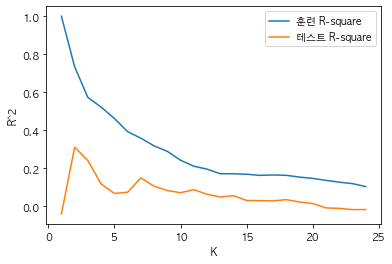

In [112]:
# K의 변황량에 따른 예측정확도 성능 비교
plt.plot(k_settings, training_rsquare, label="훈련 R-square")
plt.plot(k_settings, test_rsquare, label="테스트 R-square")
plt.ylabel("R^2")
plt.xlabel("K")
plt.legend()

In [113]:
# 최적의 K 판단
from itertools import compress
best_k_temp = test_rsquare==max(test_rsquare)
best_k = list(compress(k_settings, best_k_temp))[0]
print('최적의 K값:', best_k)

최적의 K값: 2


In [114]:
# 최적의 K값에서 테스트 데이터의 Y예측값
best_corolla_knn = KNeighborsRegressor(n_neighbors=best_k)
best_corolla_knn.fit(X_train_kr, Y_train)
Y_predict_kr = best_corolla_knn.predict(X_test_kr)
print(Y_predict_kr)

[[101.5]
 [128.5]
 [141. ]
 [168. ]
 [197. ]
 [392. ]
 [164.5]
 [174. ]
 [277. ]
 [365. ]
 [350.5]
 [365. ]
 [230.5]
 [237.5]
 [230.5]
 [252. ]
 [224.5]
 [233.5]
 [308. ]
 [245. ]
 [225.5]
 [123. ]
 [164.5]
 [636.5]
 [176.5]
 [245.5]
 [288. ]
 [129. ]
 [241.5]
 [237.5]
 [164. ]
 [214. ]
 [397. ]
 [166. ]
 [350.5]
 [365. ]
 [174. ]
 [350. ]
 [171. ]
 [327. ]
 [176. ]
 [216.5]
 [365. ]
 [192.5]
 [337.5]
 [263. ]
 [161.5]
 [245. ]
 [142.5]
 [289. ]
 [277. ]
 [233.5]
 [274.5]]


In [115]:
# MSE(mean squared error), R-squared (모형 성능 비교)
mae_kr = mean_absolute_error(Y_test, Y_predict_kr)
mae_lr = mean_absolute_error(Y_test, Y_predict)
mse_kr = mean_squared_error(Y_test, Y_predict_kr)
mse_lr = mean_squared_error(Y_test, Y_predict)
rmse_kr = np.sqrt(mse_kr)
rmse_lr = np.sqrt(mse)
r_square_kr = r2_score(Y_test, Y_predict_kr)
r_square_lr = r2_score(Y_test, Y_predict)
print('MAE from KNN Regression : {0:.3f}'.format(mae_kr))
print('MAE from Linear Regression : {0:.3f}'.format(mae))
print('MSE from KNN Regression : {0:.3f}'.format(mse_kr))
print('MSE from Linear Regression : {0:.3f}'.format(mse))
print('RMSE from KNN Regression : {0:.3f}'.format(rmse_kr))
print('RMSE from Linear Regression : {0:.3f}'.format(rmse))
print('R-square from KNN Regression : {0:.3f}'.format(r_square_kr))
print('R-square from Linear Regression : {0:.3f}'.format(r_square))

MAE from KNN Regression : 70.283
MAE from Linear Regression : 62.451
MSE from KNN Regression : 8972.962
MSE from Linear Regression : 7502.665
RMSE from KNN Regression : 94.726
RMSE from Linear Regression : 86.618
R-square from KNN Regression : 0.311
R-square from Linear Regression : 0.424


## 선형회귀와 KNN 분석 비교
* 해당 데이터셋의 경우, 모든 면에서 KNN보다 선형 회귀가 더 우수하게 나옴
수업시간엔, 복잡한 regression 모델보다 간단한 KNN이 유효한 결과를 보여주는 경우가 많았지만 항상 그런 것은 아님을 시사한다.
* **모든 상황에 절대적으로 좋은 모델은 존재하지 않는다**는 점을 다시 한 번 확인했다.

# 2-5. 선형 회귀 (2020년 모든 구 선형 회귀 + 7개년 변인 발생 추이와 함께 요인 분석)

> 선형회귀 데이터에 타임시리즈가 포함되면 안된다는 피드백을 반영해, 20년만 모든 구에 대해서 선형 회귀 분석을 진행하고 7개년 변인들의 추이 꺾은선 그래프와 함께 예방 정책의 효과를 분석해보았다.

## 2020년 기준 서울시 모든 구에 대해서 해당 변인들 선형 회귀

In [116]:
condition = (X_origin["기간"] == 2020)
X_2020=X_origin[condition]
X_2020

,자치구,기간,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
6,강남구,2020,5191,942,402,40
13,강동구,2020,8089,614,208,500
20,강북구,2020,10573,588,157,20
27,강서구,2020,3144,356,284,397
34,관악구,2020,10286,331,267,196
41,광진구,2020,3215,175,90,501
48,구로구,2020,6882,415,107,110
55,금천구,2020,12893,508,118,506
62,노원구,2020,2967,386,62,63
69,도봉구,2020,7092,168,66,369


In [117]:
X_2020.reset_index(inplace = True)
X_2020=X_2020[['자치구', '기간', '스카우트 호출 횟수', '설치 증감 수', '단란+유흥', '비상벨 수']]

In [118]:
X_2020

,자치구,기간,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
0,강남구,2020,5191,942,402,40
1,강동구,2020,8089,614,208,500
2,강북구,2020,10573,588,157,20
3,강서구,2020,3144,356,284,397
4,관악구,2020,10286,331,267,196
5,광진구,2020,3215,175,90,501
6,구로구,2020,6882,415,107,110
7,금천구,2020,12893,508,118,506
8,노원구,2020,2967,386,62,63
9,도봉구,2020,7092,168,66,369


In [119]:
X_2020=X_2020.drop(['자치구','기간'], axis=1)
X_2020

,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
0,5191,942,402,40
1,8089,614,208,500
2,10573,588,157,20
3,3144,356,284,397
4,10286,331,267,196
5,3215,175,90,501
6,6882,415,107,110
7,12893,508,118,506
8,2967,386,62,63
9,7092,168,66,369


In [120]:
# intercept 추가
X_2020 = sm.add_constant(X_2020, has_constant='add')
X_2020.head()

,const,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
0,1.0,5191,942,402,40
1,1.0,8089,614,208,500
2,1.0,10573,588,157,20
3,1.0,3144,356,284,397
4,1.0,10286,331,267,196


In [121]:
Y_2020

,강간추행 발생
0,708
1,188
2,159
3,265
4,403
5,255
6,197
7,117
8,169
9,82


In [122]:
# 학습 데이터, 테스트 데이터 분리
X_2020_train, X_2020_test, Y_2020_train, Y_2020_test = train_test_split(X_2020, Y_2020, train_size=0.7, test_size=0.3, random_state=1234)
print(X_2020_train.shape, X_2020_test.shape, Y_2020_train.shape, Y_2020_test.shape)

(17, 5) (8, 5) (17, 1) (8, 1)


In [123]:
# 회귀 모델 생성
lm = sm.OLS(Y_2020_train, X_2020_train)
lm_train = lm.fit()

In [124]:
lm_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                강간추행 발생   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     2.856
Date:                Thu, 09 Dec 2021   Prob (F-statistic):             0.0710
Time:                        18:01:01   Log-Likelihood:                -102.53
No. Observations:                  17   AIC:                             215.1
Df Residuals:                      12   BIC:                             219.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.2404    118.158      0.137      0.893    -241.203     273.684
스카우트 호출 횟수    -0.0007      0.008     -0.084      0.935      -0.019       0.017
설치 증감 수        0.1461      0.127      1.150      0.273      -0.131       0.423
단란+유흥          0.7839      0.322      2.431      0.032       0.081       1.486
비상벨 수          0.1632      0.168      0.972      0.350      -0.203       0.529
==============================================================================
Omnibus:                        4.283   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                2.648
Skew:                           0.964   Prob(JB):                        0.266
Kurtosis:                       3.132   Cond. No.                     3.95e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 분석
* 타임시리즈 데이터를 제외하고 2020년 모든 구 데이터를 돌려본 결과, F-statistic의 P-value가 0.05 이상으로 무의미한 분석결과가 나왔다.
* 이는 스카우트 호출 횟수나 CCTV 보수, 신규 설치 수는 사후에 조치되는 변인이기에 큰 영향을 끼치지 않기 때문이라고 판단했다.


## 단란주점, 유흥주점의 수가 성범죄에 얼마나 큰 영향력을 가지고 있는 지 알아보기 위해 단란, 유흥주점의 수만 변인으로 설정하여 회귀분석을 돌려보기로 하였다.

> 위 분석결과 중 유일하게 P-value가 0.05 이하로 나온 단란주점, 유흥주점을 중점적으로 분석

In [125]:
X_2020 = X_2020.drop(['스카우트 호출 횟수', '설치 증감 수','비상벨 수'], axis=1)
X_2020

,const,단란+유흥
0,1.0,402
1,1.0,208
2,1.0,157
3,1.0,284
4,1.0,267
5,1.0,90
6,1.0,107
7,1.0,118
8,1.0,62
9,1.0,66


In [126]:
# 학습 데이터, 테스트 데이터 분리
X_2020_train, X_2020_test, Y_2020_train, Y_2020_test = train_test_split(X_2020, Y_2020, train_size=0.7, test_size=0.3, random_state=1234)
print(X_2020_train.shape, X_2020_test.shape, Y_2020_train.shape, Y_2020_test.shape)

(17, 2) (8, 2) (17, 1) (8, 1)


In [127]:
# 회귀 모델 생성
lm = sm.OLS(Y_2020_train, X_2020_train)
lm_train = lm.fit()

In [128]:
lm_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                강간추행 발생   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     9.181
Date:                Thu, 09 Dec 2021   Prob (F-statistic):            0.00844
Time:                        18:01:01   Log-Likelihood:                -104.16
No. Observations:                  17   AIC:                             212.3
Df Residuals:                      15   BIC:                             214.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.1009     54.781      1.846      0.085     -15.663     217.865
단란+유흥          0.8399      0.277      3.030      0.008       0.249       1.431
==============================================================================
Omnibus:                        3.365   Durbin-Watson:                   1.459
Prob(Omnibus):                  0.186   Jarque-Bera (JB):                1.782
Skew:                           0.783   Prob(JB):                        0.410
Kurtosis:                       3.254   Cond. No.                         378.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 분석

* 단란 유흥주점의 수만 넣으니 F-statistic의 P-value가 0.05 이하로 유의미한 분석결과가 나왔으며, R-squared도 0.2 이상으로 좋은 모델이 나왔다.
* 변수가 단란, 유흥주점의 수 하나로 줄어들었는데도 불구하고 R-squared가 0.1밖에 하락하지 않았다. 
* 이를 통해, 단란 주점과 유흥업소의 수가 성범죄에 있어서 아주 큰 영향을 미치는 것을 알 수 있다.
### 이를 통해 **변인이 많아야만 좋은 것이 아니라, 좋은 변인이 있다면 한가지 변인으로도 유의미하고 중요한 의미를 가질 수 있다**는 것을 알 수 있었다.


## 각 변인과 강간 및 전국 강제추행 총량의 추이를 꺾은선 그래프로 나타내어 상관관계 및 변화량 분석

In [129]:
condition = (Bell["기간"] == 2020)
Bell2=Bell[condition]
Bell2

,자치구,기간,비상벨 수
6,강남구,2020,40
13,강동구,2020,500
20,강북구,2020,20
27,강서구,2020,397
34,관악구,2020,196
41,광진구,2020,501
48,구로구,2020,110
55,금천구,2020,506
62,노원구,2020,63
69,도봉구,2020,369


In [130]:
condition = (Bell["기간"] == 2019)
Bell3=Bell[condition]
Bell3

,자치구,기간,비상벨 수
5,강남구,2019,40
12,강동구,2019,500
19,강북구,2019,20
26,강서구,2019,397
33,관악구,2019,196
40,광진구,2019,501
47,구로구,2019,110
54,금천구,2019,504
61,노원구,2019,63
68,도봉구,2019,369


In [131]:
condition = (Bell["기간"] == 2018)
Bell4=Bell[condition]
Bell4

,자치구,기간,비상벨 수
4,강남구,2018,39
11,강동구,2018,482
18,강북구,2018,20
25,강서구,2018,397
32,관악구,2018,196
39,광진구,2018,501
46,구로구,2018,105
53,금천구,2018,451
60,노원구,2018,63
67,도봉구,2018,369


In [132]:
condition = (Bell["기간"] == 2017)
Bell5=Bell[condition]
Bell5

,자치구,기간,비상벨 수
3,강남구,2017,39
10,강동구,2017,398
17,강북구,2017,20
24,강서구,2017,397
31,관악구,2017,179
38,광진구,2017,457
45,구로구,2017,105
52,금천구,2017,217
59,노원구,2017,63
66,도봉구,2017,202


In [133]:
condition = (Bell["기간"] == 2016)
Bell6=Bell[condition]
Bell6

,자치구,기간,비상벨 수
2,강남구,2016,37
9,강동구,2016,301
16,강북구,2016,4
23,강서구,2016,381
30,관악구,2016,150
37,광진구,2016,0
44,구로구,2016,100
51,금천구,2016,41
58,노원구,2016,0
65,도봉구,2016,189


In [134]:
condition = (Bell["기간"] == 2015)
Bell7=Bell[condition]
Bell7

,자치구,기간,비상벨 수
1,강남구,2015,0
8,강동구,2015,217
15,강북구,2015,0
22,강서구,2015,317
29,관악구,2015,115
36,광진구,2015,0
43,구로구,2015,96
50,금천구,2015,16
57,노원구,2015,0
64,도봉구,2015,102


In [135]:
Histogram1 = pd.read_excel('/Users/choohyunho/Desktop/머신러닝 팀플 최종/서울 데이터 통합2.xlsx')

In [136]:
Histogram1

,연도,CCTV 증감,스카우트 호출 횟수,유흥 단란 주점 수,비상벨 수,Ocurrence
0,2014,4439,0,5189,965,5462
1,2015,6582,235305,5073,1795,5449
2,2016,8129,243854,4923,3127,6002
3,2017,9947,324721,4888,4403,6963
4,2018,9876,343180,4680,5181,6412
5,2019,11961,352974,4408,5352,6469
6,2020,11132,212298,4115,5727,5763


<Figure size 432x288 with 0 Axes>

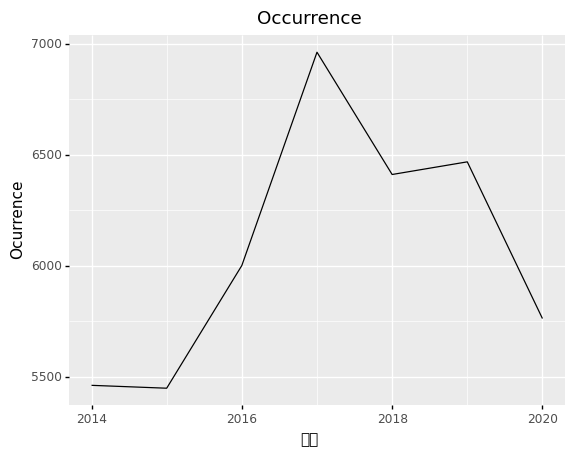

<ggplot: (8774568416479)>

In [137]:
from plotnine import*
fig = plt.figure()

(ggplot(Histogram1, aes(x="연도", y='Ocurrence'))
+geom_line()
+ggtitle('Occurrence'))

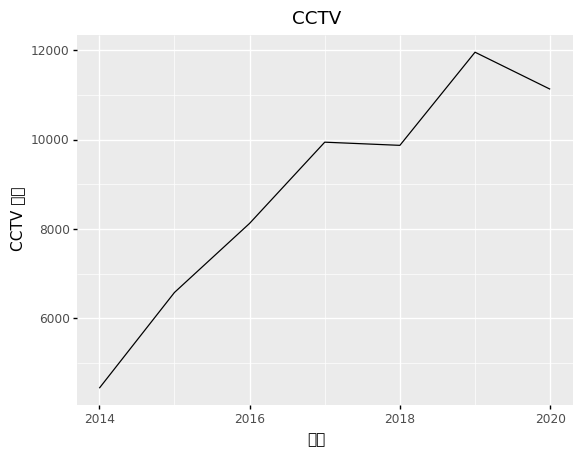

<ggplot: (8774568727848)>

In [138]:
(ggplot(Histogram1, aes(x="연도", y='CCTV 증감'))
+geom_line()
+ggtitle('CCTV'))

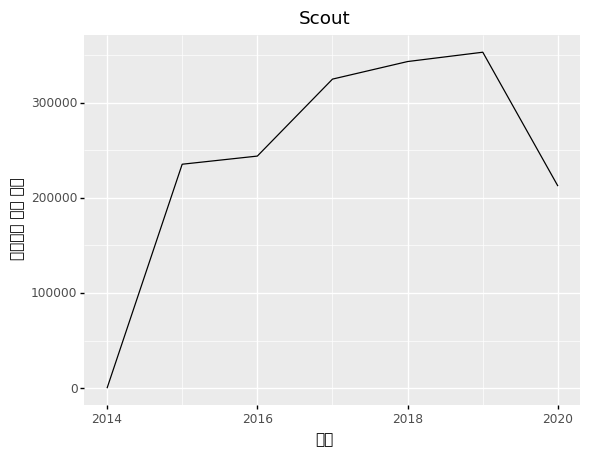

<ggplot: (8774564329500)>

In [139]:
(ggplot(Histogram1, aes(x="연도", y='스카우트 호출 횟수'))
+geom_line()
+ggtitle('Scout'))

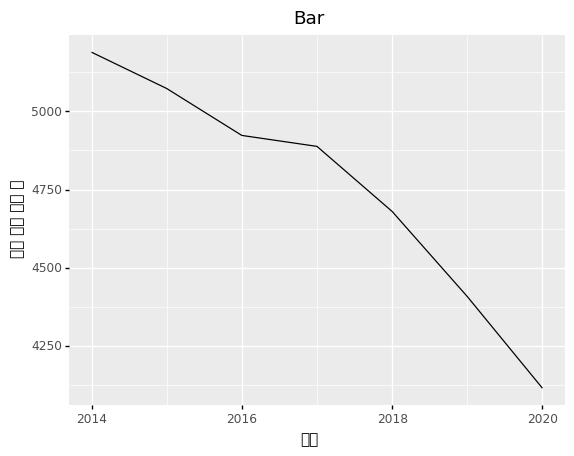

<ggplot: (8774562956891)>

In [140]:
(ggplot(Histogram1, aes(x="연도", y='유흥 단란 주점 수'))
+geom_line()
+ggtitle('Bar'))

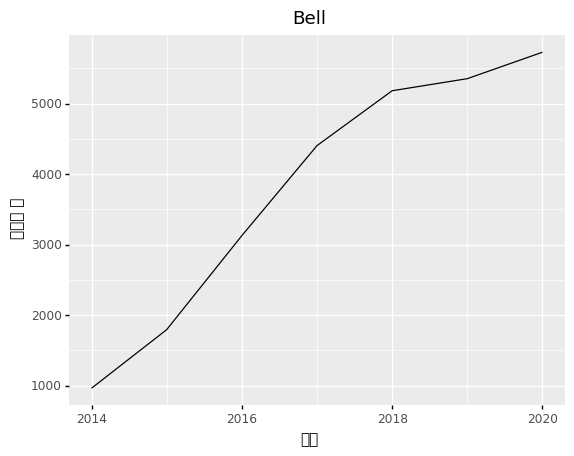

<ggplot: (8774564270270)>

In [141]:
(ggplot(Histogram1, aes(x="연도", y='비상벨 수'))
+geom_line()
+ggtitle('Bell'))

### 전처리 하이라이트

- 독립변수 3개의 콜롬명 중 '중구' 가 
cctv 만 띄어쓰기가 포함되어 '중 구' 로 표기되어 있었음

## 분석 
* 발생량: 15년부터 꾸준하게 상승하다 17년도 기점으로 줄어들기 시작했다. 

* 유흥업소: 유흥업소는 14년도 이후로 꾸준하게 줄어들었다. 하지만 이전의 회귀분석 결과로 유추해본다면, 유흥업소 수는 성범죄에 대해 높은 상관계수를 가지는 변인이었기 때문에 유흥업소 수 자체는 줄었지만 개별 성폭력 범죄는 여전히 증가하고있다.

* CCTV 설치 및 교체 수: 17-18년도, 19-20년도 제외 상승하는 그래프이다. 성범죄의 대응책으로서 가장 민감하게 상승하며, 이를 통해 안전해지고 있다는 것을 알 수 있다.

* 스카우트: 15년도부터 시행했기 때문에 0개인 14년도부터 15년도까지의 변화폭은 분석할 의미가 없다. 스카우트 호출 횟수는 15-19년도엔 상승하고, 19-20년도엔 하락한다. 여성시민들이 스카우트를 호출하며 안전을 확보했기에 발생량이 줄었다고 볼 수 있다.

* 비상벨 수: CCTV와 달리 비상벨 수는 전체 대수이기 때문에 정식 시행년도 이후로 증가 후 안정권에 들어서고 있다는 것을 볼 수 있다.


# 2-6. 이번 프로젝트의 주제 : 14-19년 데이터 회귀분석 토대로 2020년 예측
> 이번 프로젝트의 주요 목적인 2014년에서 2019년까지의 회귀분석을 토대로 2020년의 성범죄 발생 수 예측을 시도하기 위해 머신러닝을 돌려보고 결과를 비교해보기로 하였다

* 본래 선형회귀분석 진행 시 타임시리즈가 포함이 되면 안되지만, 각 년도의 특정 구가 전년도와는 다른 지역이라는 가정 하에 모든 연도 모든 구 데이터에 대한 선형회귀 분석을 진행한 데이터로 머신러닝의 주 목적인 결과 예측을 진행해보았다.

In [142]:
X_origin

,자치구,기간,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
0,강남구,2014,0,597,604,0
1,강남구,2015,3341,840,582,0
2,강남구,2016,2448,1310,556,37
3,강남구,2017,6863,999,520,39
4,강남구,2018,8793,748,477,39
5,강남구,2019,6306,789,448,40
6,강남구,2020,5191,942,402,40
7,강동구,2014,0,49,256,28
8,강동구,2015,12797,154,250,217
9,강동구,2016,15910,202,214,301


In [143]:
index1 = X_origin[X_origin['기간'] == 2020].index
index1

Int64Index([  6,  13,  20,  27,  34,  41,  48,  55,  62,  69,  76,  83,  90,
             97, 104, 111, 118, 125, 132, 139, 146, 153, 160, 167, 174],
           dtype='int64')

In [144]:
X_1419 = X_origin.drop(index1)
X_1419 = X_1419.drop(['자치구','기간'], axis=1)
X_1419

,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
0,0,597,604,0
1,3341,840,582,0
2,2448,1310,556,37
3,6863,999,520,39
4,8793,748,477,39
5,6306,789,448,40
7,0,49,256,28
8,12797,154,250,217
9,15910,202,214,301
10,18930,273,238,398


In [145]:
# intercept 추가
X_1419 = sm.add_constant(X_1419, has_constant='add')
X_1419.head()

,const,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
0,1.0,0,597,604,0
1,1.0,3341,840,582,0
2,1.0,2448,1310,556,37
3,1.0,6863,999,520,39
4,1.0,8793,748,477,39


In [146]:
LR_SC

,자치구,기간,강간추행 발생
0,강남구,2014,512
1,강남구,2015,449
2,강남구,2016,516
3,강남구,2017,607
4,강남구,2018,600
5,강남구,2019,666
6,강남구,2020,708
7,강동구,2014,148
8,강동구,2015,156
9,강동구,2016,160


In [147]:
index2 =LR_SC[LR_SC['기간'] == 2020].index
index2

Int64Index([  6,  13,  20,  27,  34,  41,  48,  55,  62,  69,  76,  83,  90,
             97, 104, 111, 118, 125, 132, 139, 146, 153, 160, 167, 174],
           dtype='int64')

In [148]:
Y_1419 = LR_SC.drop(index1)
Y_1419 = Y_1419.drop(['자치구','기간'], axis=1)
Y_1419

,강간추행 발생
0,512
1,449
2,516
3,607
4,600
5,666
7,148
8,156
9,160
10,172


In [149]:
# 학습 데이터, 테스트 데이터 분리
X_1419_train, X_1419_test, Y_1419_train, Y_1419_test = train_test_split(X_1419, Y_1419, train_size=0.7, test_size=0.3, random_state=1234)
print(X_1419_train.shape, X_1419_test.shape, Y_1419_train.shape, Y_1419_test.shape)

(105, 5) (45, 5) (105, 1) (45, 1)


In [150]:
# 회귀 모델 생성
lm = sm.OLS(Y_1419_train, X_1419_train)
lm_train = lm.fit()

In [151]:
lm_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                강간추행 발생   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     21.97
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           4.95e-13
Time:                        18:01:02   Log-Likelihood:                -618.87
No. Observations:                 105   AIC:                             1248.
Df Residuals:                     100   BIC:                             1261.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.7785     23.082      2.676      0.009      15.984     107.573
스카우트 호출 횟수     0.0032      0.001      2.767      0.007       0.001       0.005
설치 증감 수        0.1045      0.036      2.932      0.004       0.034       0.175
단란+유흥          0.5199      0.077      6.746      0.000       0.367       0.673
비상벨 수          0.1000      0.059      1.694      0.093      -0.017       0.217
==============================================================================
Omnibus:                       22.111   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.644
Skew:                           1.027   Prob(JB):                     2.22e-07
Kurtosis:                       4.669   Cond. No.                     3.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 이를 바탕으로 2020년을 예측하여 실제 성범죄 발생량과 비교해 보고 결과를 예측 가능했는가를 살펴보기로 하였다.

> 따라서 각 구별 변인의 수치에 각 변인 별 계수를 곱한 총계를 구별로 내어보았다.

In [152]:
condition = X_origin['기간']==2020
X_origin = X_origin[condition]
X_origin

,자치구,기간,스카우트 호출 횟수,설치 증감 수,단란+유흥,비상벨 수
6,강남구,2020,5191,942,402,40
13,강동구,2020,8089,614,208,500
20,강북구,2020,10573,588,157,20
27,강서구,2020,3144,356,284,397
34,관악구,2020,10286,331,267,196
41,광진구,2020,3215,175,90,501
48,구로구,2020,6882,415,107,110
55,금천구,2020,12893,508,118,506
62,노원구,2020,2967,386,62,63
69,도봉구,2020,7092,168,66,369


In [153]:
X_origin['Predict_2020'] = X_origin['스카우트 호출 횟수']*0.0032+X_origin['설치 증감 수']*0.1045+X_origin['단란+유흥']*0.5199+X_origin['비상벨 수']*0.1

In [154]:
Predict_2020 = np.array(X_origin['Predict_2020'])
Predict_2020

array([328.05  , 248.187 , 178.9039, 234.6144, 225.918 , 125.4665,
       132.0192, 206.2918,  88.3652, 111.4638, 166.8126, 206.4828,
       157.3667, 123.2521, 165.242 , 115.8987, 106.8081, 243.1681,
        91.7561, 308.956 , 171.7215, 166.1816, 219.6139, 220.9701,
       204.762 ])

In [155]:
condition2 = LR_SC['기간']==2020
Y= LR_SC[condition2]
Y

,자치구,기간,강간추행 발생
6,강남구,2020,708
13,강동구,2020,188
20,강북구,2020,159
27,강서구,2020,265
34,관악구,2020,403
41,광진구,2020,255
48,구로구,2020,197
55,금천구,2020,117
62,노원구,2020,169
69,도봉구,2020,82


In [156]:
Y_2020_np = np.array(Y_2020['강간추행 발생'])
Y_2020_np

array([708, 188, 159, 265, 403, 255, 197, 117, 169,  82, 161, 226, 348,
       159, 396, 115, 142, 287, 109, 315, 230, 171, 192, 186, 183])

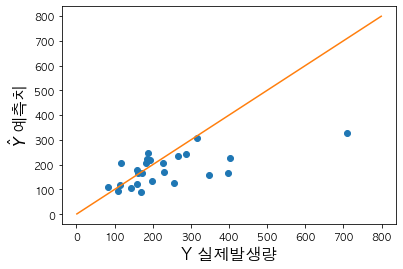

In [157]:
plt.plot(Y_2020_np,Predict_2020, 'o')
x = np.arange(1,800)
y = x
plt.plot(x,y)
plt.xlabel('Y 실제발생량', size=16)
plt.ylabel('$\hat{Y}$ 예측치', size=16)
plt.show()

많은 점들이 y=x 그래프에 가까이 있는 것을 볼 수 있다. 이는 실제 성범죄 발생량과 유사하게 예측했다고 볼 수 있음
하지만 강남구 데이터의 경우, 유독 예측치에 크게 벗어난 모습을 보임

# 3. 2020년도 강남구 성범죄 예측값과 발생량 차이 원인 분석         

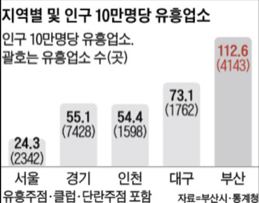

In [7]:
from IPython.display import Image


Image("/Users/choohyunho/Desktop/머신러닝 팀플 최종/인구당업소.png")

#출처 : https://www.hankyung.com/news/article/2011061442727

유동인구

- 강남구는 유동인구 2위
- 따라서, 구별 유흥업소 수를 분석하기 보다는, 유동인구(외부유입) X (유흥업소 수) 로 변인을 채택한다면 더 좋은 예측결과가 나올 수 있지 않았을까 유추해보았다.

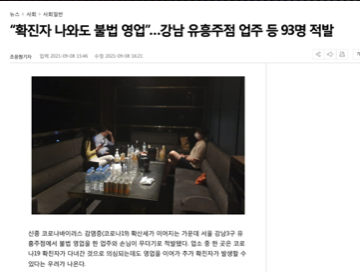

In [6]:
from IPython.display import Image


Image("/Users/choohyunho/Desktop/머신러닝 팀플 최종/불법영업1.png")

#출처 : https://www.donga.com/news/Society/article/all/20210908/109155509/1

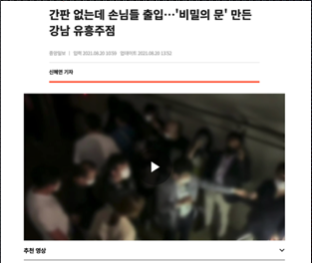

In [5]:
from IPython.display import Image


Image("/Users/choohyunho/Desktop/머신러닝 팀플 최종/불법영업2.png")

#출처 : https://www.joongang.co.kr/article/24132139#home

불법영업

- 코로나 및 여타 이유로 불법영업으로 영업 시간 제한, 영업 정지 및 제한을 받은 가게들이 있다.
- 조사해보니 장소를 바꾸거나 간판을 달지 않고 암암리에 유흥 서비스를 제공하였기 때문에 독립변수의 수는 '실제로는' 줄어들지 않았다.
- 음지에 있기에 더욱 범죄에 취약한 공간이 형성되었기 때문이지 않을까 유추해보았다.


# 4. 결론

## 요약  

"변인 선정과 분석을 통한 14'-19' 회귀분석과 20 서울시 성범죄 발생 수 결과 예측"이라는 주제로 연구를 진행하였다. 가장 먼저 지역 발생수의 양상을 파악한 결과 강남구가 최대값을 가진다는 점을 확인했고,‘발생장소별' 현황 통계를 통해  노상, 주거공간, 유흥업소라는 장소를 도출했다. 이를 바탕으로 구별 유흥단란주점 수, 안전비상벨, 여성 안심귀가 스카우트 제도, 구별 CCTV 신규 설치 수 데이터 셋을 조사해 회귀분석의 독립변수로 활용하기로 결정했다. 가장 많은 성범죄가 발생하는 강남구 먼저 국소적으로 선형회귀를 진행해본 결과, 데이터셋이 너무 작다는 오류가 있었고 모든 연도 모든 구 데이터로 선형 회귀와 KNN 분석, 각 방법론을 비교해보았을 때는 선형회귀 데이터에 타임시리즈를 포함하면 안된다는 오류가 있었다. 따라서 20년만 모든 구에 대해 다시 한 번 선형회귀를 진행했고 그 결과, 단란+유흥 주점 변인이 좋지 않은 회귀분석 결과에서도 큰 상관관계를 보였다는 점에서 특이점을 느꼈다. 해당 변인의 영향력을 알아보기 위해 유흥단란주점 수만 변인으로 회귀분석을 진행하였고 유의미하다는 결과를 얻었다. 마지막으로 변수에 타임시리즈 포함을 감안하고 연구의 목적인 "14'-19' 회귀분석과 20 서울시 성범죄 발생 수 결과 예측"을 진행한 결과 실제 2020년 성범죄 발생량과 유사한 예측값이 나왔다.

## 연구의 의미

본 프로젝트는 공공데이터를 수집하여 선형회귀 모형을 통해 서울시 성범죄 발생 수 결과를 예측하고 성범죄의 원인과 예방정책 분석을 목적으로 한다. 
먼저 서울시 성범죄 발생량을 예측하기 위해 14-19년도의 모든 구 데이터를 대상으로 회귀분석을 진행해 예측모형을 도출하여, 서울시 2020년 성범죄 발생량을 예측할 수 있었다. 이를 바탕으로 서울시 2020년 성범죄 실제 발생량과 비교한 결과, 대체적으로 유사한 수치를 보였다. 하지만 강남구의 경우 유독 예측치에 벗어난 모습을 보였는데 이는 유동인구와 불법영업의 수를 고려하지 못했기 때문인 것으로 유추된다.
회귀 분석과 꺾은선 그래프를 바탕으로 예방 정책들을 분석해본 결과, 먼저 유흥업소는 그 수가 계속 줄어드는 반면 개별 성폭력 범죄 밀도는 증가했다. 따라서 회귀 분석상으로도 유의미한 변수인 유흥업소의 개별적 단속을 더욱 강화해야 한다는 결론을 내렸다. 나머지 정책들은 회귀분석 상으로는 큰 영향력이 없었지만 꺾은선 상으로 비슷한 변화 추이를 보여줬다. 따라서 CCTV, 비상벨, 스카우트는 성폭력 범죄의 사후 조치 및 미미한 대응책으로 결론을 내렸다.

## 한계 및 느낀점

#### 한계점
수집한 데이터가 일관성 있게 가공되어 있지 않아 전처리에 시간을 많이 소요했기에. 더 양질의 데이터셋을 찾았으면 하는 아쉬움이 남는다.  또한 데이터셋을 구별 데이터로 정하고 수집했는데, 이는 대량의 데이터를 수집하는 것에 무리가 있는 기준 선정이었다.  회귀분석에 있어서는 데이터셋이 8개보다 작거나 변수에 타임시리즈가 들어가 시간변수는 correlation(데이터간 상관관계)이 있어 독립적이지 않다는 점을 뒤늦게 파악하는 등 선형회귀에 대해 사전조사가 미흡했던 한계점이 있다.

#### 느낀점
모두 머신러닝 경험이 없는 상태에서 시작했는데 차근차근 주제를 정하고 각자 공부를 해와서 매주 오프라인으로 프로젝트를 진행했기 때문에 다같이 만들어낸 결과물에 모두 굉장히 큰 자부심을 느꼈다. 자유로운 분위기 속에서 데이터를 준비해오고 가공하며, 새로운 아이디어를 내는데에 적극적이었기 때문에 빠르게 프로젝트 진행 방향을 변경하거나 진행되었던 산출물을 수정해가며 유의미한 결과를 낼 수 있었다. 데이터 및 주제선정에 여러 타협이 있었고 그에 따른 결과가 완벽하지 않았더라도 수업 내용을 적용하고 공부할 수 있는 좋은 기회였다고 생각한다. 수 많은 오류 메시지와 공무원들의 데이터 입력 실수 등 많은 난관에 봉착했지만, 팀원들의 날카로운 분석과 구글링 실력으로 신속하게 해결해낼 수 있었다. 발표 직전까지 끊임없이 피드백을 반영해 최선을 다한 머신러닝 8팀 최고!